## Compute Sagnac Frequency - Backscatter Correction - Frequency Domain

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read
from scipy.signal import hilbert

In [2]:
from functions.load_romy_raw_data import __load_romy_raw_data
from functions.hilbert_frequency_estimator import __hilbert_frequency_estimator
from functions.get_fft_values import __get_fft_values
# from functions.multitaper_psd import __multitaper_psd
# from functions.welch_psd import __welch_psd
# from acoustics.signal import phase_spectrum
from functions.get_time_intervals import __get_time_intervals
from functions.backscatter_correction import __backscatter_correction

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [119]:
config = {}

config['ring'] = "Z"

config['seed'] = f"BW.DROMY..FJ{config['ring']}"

config['path_to_sds'] = archive_path+"romy_archive/"

# test U
config['tbeg'] = UTCDateTime("2023-09-19 00:00")
config['tend'] = UTCDateTime("2023-09-19 02:00")

# test V
config['tbeg'] = UTCDateTime("2024-05-22 16:00")
config['tend'] = UTCDateTime("2024-05-22 19:00")

# test Z
config['tbeg'] = UTCDateTime("2024-08-01 15:30")
config['tend'] = UTCDateTime("2024-08-01 18:30")

# define nominal sagnac frequency of rings
config['ring_sagnac'] = {"U":303.05, "V":447.5, "W":447.5, "Z":553.5}
config['nominal_sagnac'] = config['ring_sagnac'][config['ring']]

## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"


### Load Archive Files

In [120]:
sagn = __load_romy_raw_data(f"BW.DROMY..FJ{config['ring']}", config['tbeg'], config['tend'], config['path_to_sds'])
mon1 = __load_romy_raw_data("BW.DROMY..F1V", config['tbeg'], config['tend'], config['path_to_sds'])
mon2 = __load_romy_raw_data("BW.DROMY..F2V", config['tbeg'], config['tend'], config['path_to_sds'])

 -> loading BW.DROMY..FJZ...
 -> loading BW.DROMY..F1V...
 -> loading BW.DROMY..F2V...


In [121]:
# for ss in [sagn, mon1, mon2]:
#     ss.write(root_path+f"Downloads/mseed/DROMY_{ss[0].stats.channel}_{config['tbeg'].date}.mseed)

### Load Local Files

In [122]:
# sagn = read(root_path+"Downloads/mseed/DROMY_FJU_2023-09-19.mseed")
# mon1 = read(root_path+"Downloads/mseed/DROMY_F1V_2023-09-19.mseed")
# mon2 = read(root_path+"Downloads/mseed/DROMY_F2V_2023-09-19.mseed")

# sagn = read(root_path+"Downloads/mseed/DROMY_FJU_2023-09-01.mseed")
# mon1 = read(root_path+"Downloads/mseed/DROMY_F1V_2023-09-01.mseed")
# mon2 = read(root_path+"Downloads/mseed/DROMY_F2V_2023-09-01.mseed")

# sagn.trim(config['tbeg'], config['tbeg']+1800)
# mon1.trim(config['tbeg'], config['tbeg']+1800)
# mon2.trim(config['tbeg'], config['tbeg']+1800)

# sagn = read(root_path+f"Downloads/mseed/DROMY_FJ{config['ring']}_{config['tbeg'].date}.mseed")
# mon1 = read(root_path+f"Downloads/mseed/DROMY_F1V_{config['tbeg'].date}.mseed")
# mon2 = read(root_path+f"Downloads/mseed/DROMY_F2V_{config['tbeg'].date}.mseed")

# for st0 in [sagn, mon1, mon2]:
#     for tr in st0:
#         tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]


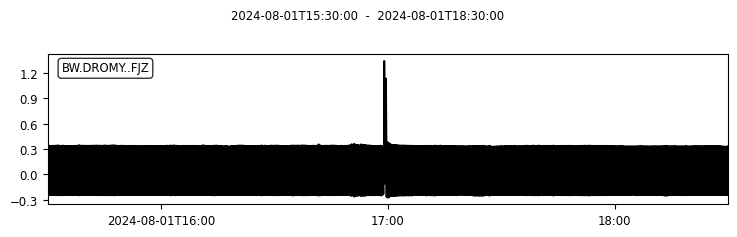

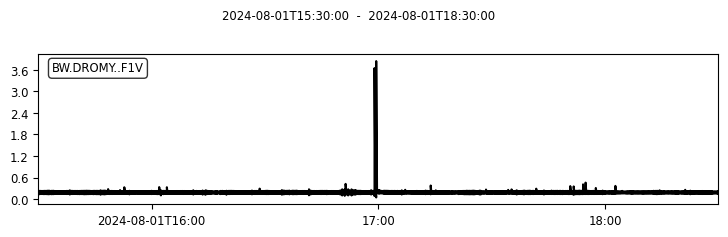

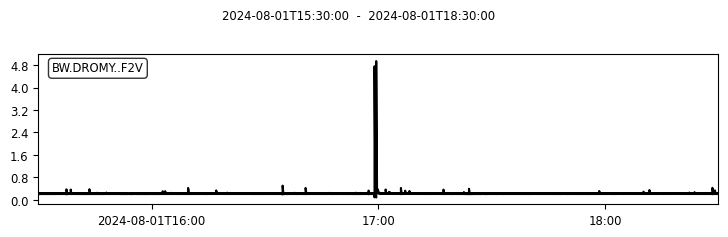

In [123]:
sagn.plot();
mon1.plot();
mon2.plot();

## Processing

In [124]:
# def __get_values(ff, psd, pha, f_sagn):

#     from numpy import argmax, sqrt, where, argmin, gradient, mean

#     ## specify f-band around Sagnac frequency
#     fl = f_sagn-2
#     fu = f_sagn+2

#     ## get index of Sagnac peak
#     idx_fs = where(psd == max(psd[(ff > fl) & (ff < fu)]))[0][0]

#     ## estimate Sagnac frequency
#     f_sagn_est = ff[idx_fs]

#     ## estimate AC value at Sagnac peak
#     AC_est = psd[idx_fs]

#     ## estimate DC value at ff = 0
#     DC_est = psd[0]
#     # DC_est = psd[0] /2

#     ## phase at Sagnac frequency
#     ph_est = pha[idx_fs]

#     return f_sagn_est, AC_est, DC_est, ph_est

In [125]:
# def __get_fft(signal_in, dt, window=None):

#     from scipy.fft import fft, fftfreq, fftshift
#     from scipy import signal
#     from numpy import angle

#     ## determine length of the input time series
#     n = int(len(signal_in))


#     ## calculate spectrum (with or without window function applied to time series)
#     if window:
#         win = signal.get_window(window, n);
#         spectrum = fft(signal_in * win, norm="forward")

#     else:
#         spectrum = fft(signal_in, norm="forward")

#     ## calculate frequency array
#     frequencies = fftfreq(n, d=dt)

#     ## correct amplitudes of spectrum
#     magnitude = 2.0 / n * abs(spectrum)

#     ## phase angle
#     phase = angle(spectrum, deg=False)

#     return frequencies[0:n//2], magnitude[0:n//2], phase[0:n//2]

In [126]:
# def __get_fft_values(signal_in, dt, f_sagn, window=None):

#     from numpy import argmax, sqrt, where, argmin, gradient, mean
#     from scipy.fft import fft, fftfreq, fftshift
#     from scipy import signal
#     from numpy import angle, imag, unwrap

#     ## determine length of the input time series
#     n = int(len(signal_in))

#     signal_in = fftshift(signal_in)

#     ## calculate spectrum (with or without window function applied to time series)
#     if window:
#         win = signal.get_window(window, n);
#         spectrum = fft(signal_in * win, norm="forward")

#     else:
#         spectrum = fft(signal_in, norm="forward")

#     ## calculate frequency array
#     frequencies = fftfreq(n, d=dt)

#     ## correct amplitudes of spectrum
#     magnitude_corrected = abs(spectrum) *2 /n

#     ## none corrected magnitudes
#     magnitude = abs(spectrum)

#     ## phase spectrum
#     phase = angle(spectrum, deg=False)

#     freq = frequencies[0:n//2]
#     spec = magnitude[0:n//2]
#     pha = phase[0:n//2]


#     ## specify f-band around Sagnac frequency
#     fl = f_sagn - 2
#     fu = f_sagn + 2

#     ## get index of Sagnac peak
#     idx_fs = where(spec == max(spec[(freq > fl) & (freq < fu)]))[0][0]

#     ## estimate Sagnac frequency
#     f_sagn_est = freq[idx_fs]

#     ## estimate AC value at Sagnac peak
#     AC_est = spec[idx_fs] * 2

#     ## estimate DC value at ff = 0
#     DC_est = spec[0]

#     ## estimate phase at Sagnac peak
#     phase_est = pha[idx_fs] ## select phase of Sagnac

#     return f_sagn_est, AC_est, DC_est, phase_est

In [127]:
# def __hilbert_frequency_estimator(st, nominal_sagnac, fband, cut=0, plot=False):

#     from scipy.signal import hilbert
#     import numpy as np

#     st0 = st.copy()

#     ## extract sampling rate
#     df = st0[0].stats.sampling_rate

#     ## define frequency band around Sagnac Frequency
#     f_lower = nominal_sagnac - fband
#     f_upper = nominal_sagnac + fband

#     ## bandpass with butterworth around Sagnac Frequency
#     st0 = st0.detrend("linear")
#     st0 = st0.taper(0.01, type='cosine')
#     st0 = st0.filter("bandpass", freqmin=f_lower, freqmax=f_upper, corners=4, zerophase=True)

#     if plot:
#         x = len(st0[0].data)
#         n1, n2 = int(x/2-150),int(x/2+150)
#         plt.figure(figsize=(15,5))
#         plt.plot(st0[0].data[n1:n2])
#         plt.show()

#     ## estimate instantaneous frequency with hilbert
#     signal = st0[0].data

#     analytic_signal = hilbert(signal)
#     amplitude_envelope = np.abs(analytic_signal)
#     instantaneous_phase = np.unwrap(np.angle(analytic_signal))
#     instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * df)

#     ## cut first and last 5% (corrupted data)
#     # dd = int(cut*len(instantaneous_frequency))
#     dd = int(cut*df)
#     insta_f_cut = instantaneous_frequency[dd:-dd]

#     # plt.plot(insta_f_cut)

#     ## get times
#     t = st0[0].times()
#     t_mid = t[int((len(t))/2)]

#     ## averaging of frequencies
#     insta_f_cut_avg = np.mean(insta_f_cut)
#     # insta_f_cut_avg = np.median(insta_f_cut)

#     return t_mid, insta_f_cut_avg, np.mean(amplitude_envelope), np.std(insta_f_cut)

In [128]:
# def __hilbert_frequency_estimator2(st, nominal_sagnac, fband, cut=0):

#     from scipy.signal import hilbert
#     import numpy as np

#     st0 = st.copy()

#     ## extract sampling rate
#     df = st0[0].stats.sampling_rate

#     ## define frequency band around Sagnac Frequency
#     f_lower = nominal_sagnac - fband
#     f_upper = nominal_sagnac + fband

#     ## bandpass with butterworth around Sagnac Frequency
#     st0 = st0.detrend("linear")
#     st0 = st0.taper(0.01, type='cosine')
#     st0 = st0.filter("bandpass", freqmin=f_lower, freqmax=f_upper, corners=4, zerophase=True)

#     ## estimate instantaneous frequency with hilbert
#     signal = st0[0].data

#     ## calulcate hilbert transform
#     hil0 = hilbert(signal)

#     ## extract imaginary part of hilbert transform
#     hil = np.imag(hil0)

#     ## calculate derivatives
#     d_hil = np.gradient(hil, edge_order=1)
#     d_sig = np.gradient(signal, edge_order=1)

#     delta_f_full = (signal * d_hil - d_sig * hil) / (2*np.pi*np.sqrt(signal**2 + hil**2))

#     ## extract real part
#     instantaneous_frequency = np.real(delta_f_full)

#     del hil0, hil, d_hil, d_sig
#     ## cut first and last 5% (corrupted data)
#     # dd = int(cut*len(instantaneous_frequency))
#     dd = int(cut*df)
#     insta_f_cut = instantaneous_frequency[dd:-dd]

#     ## get times
#     t = st0[0].times()
#     t_mid = t[int((len(t))/2)]

#     ## averaging of frequencies
#     insta_f_cut_avg = np.mean(insta_f_cut)
#     # insta_f_cut_avg = np.median(insta_f_cut)

#     return t_mid, insta_f_cut_avg

## Configurations

In [129]:
config['tbeg'], config['tend'] = sagn[0].stats.starttime, sagn[0].stats.endtime

config['interval'] = 120 ## seconds

config['method'] = "fft" ## welch | multitaper | fft

config['ddt'] = 30

config['fband'] = 2

config['cm_value'] = 1.033

# set if amplitdes are corrected with envelope
config['correct_amplitudes'] = False

# set prewhitening factor (to avoid division by zero)
config['prewhitening'] = 0.001

In [130]:
times = __get_time_intervals(config['tbeg'], config['tend'], interval_seconds=config['interval'], interval_overlap=0)

## Computing

In [158]:
def __sine_fit(st0, nominal_sagnac, fband=2, Tinterval=20, Toverlap=2, plot=True):

    '''
    Fitting a sin-function to the data to estimate an instantaneous frequency
    '''

    import matplotlib.pyplot as plt

    from scipy import optimize
    from numpy import sin, hanning, pi, arange, array, diag, zeros, nan, isnan

    def func(x, a, f):
        return a * sin(2 * pi * f * x)

    def func(x, a, f, p):
        return a * sin(2 * pi * f * x + p)

    df = st0[0].stats.sampling_rate

    times = st0[0].times()

    # define frequency band around Sagnac Frequency
    f_lower = nominal_sagnac - fband
    f_upper = nominal_sagnac + fband

    # bandpass with butterworth around Sagnac Frequency
    st0 = st0.detrend("linear")
    # st0 = st0.taper(0.01)
    st0 = st0.filter("bandpass", freqmin=f_lower, freqmax=f_upper, corners=4, zerophase=True)

    # to array
    data = st0[0].data

    # npts per interval
    Nsamples = int(Tinterval*df)
    Noverlap = int(Toverlap*df)

    # npts in data
    Ndata = data.size

    # create time reference
    tt = times

    # amount of windows
    Nwin = 0
    x2 = Nsamples
    while x2 < Ndata:
        int(Ndata / (Nsamples - Noverlap))
        x2 = x2 + Nsamples - Noverlap
        Nwin += 1

    # prepare lists
    amps = zeros(Nwin)*nan
    freq = zeros(Nwin)*nan
    phas = zeros(Nwin)*nan
    time = zeros(Nwin)*nan
    cfs = zeros(Nwin)*nan
    cas = zeros(Nwin)*nan

    # initial values
    a00 = 0.9
    f00 = nominal_sagnac
    p00 = 0

    # specify start indices
    n1, n2 = 0, Nsamples

    # looping
    for _win in range(Nwin):

        # npts = Nsamples-Noverlap

        # set start values at begin
        if _win == 0:
            a0, f0, p0 = a00, f00, p00

        # reste start values if nan
        if isnan(a0) or isnan(f0) or isnan(p0):
            a0, f0, p0 = a00, f00, p00

        _time = tt[n1:n2]
        _data = data[n1:n2]

        # xx = 0
        # cf, ca = 1, 1

        # condition for fit
        # while cf > 0.001 and ca > 0.001:
        try:
            params, params_covariance = optimize.curve_fit(func,
                                                           _time,
                                                           _data,
                                                           p0=[a0, f0, p0],
                                                           check_finite=True,
                                                          )
            f0 = params[1]
            a0 = params[0]
            p0 = params[2]

            ca, cf = diag(params_covariance)[0], diag(params_covariance)[1]

        except:
            # print(f" -> fit failed {_win}")
            f0, a0, p0, ca, cf = nan, nan, nan, nan, nan

            # # counter to avoid infinitiy loop
            # if xx > 500:
            #     break
            # else:
            #     xx += 1

        if cf > 0.001 or ca > 0.001:
            f0, a0, p0 = nan, nan, nan

        # append values
        amps[_win] = a0
        freq[_win] = f0
        phas[_win] = p0
        time[_win] = (tt[n2]-tt[n1])/2 + tt[n1]

        cfs[_win] = cf
        cas[_win] = ca

        if plot:
            if _win == Nwin - 1:
                fig, ax = plt.subplots(1, 1, figsize=(15, 5))

                ax.plot(_time, _data, color='black')

                ax.plot(_time, func(_time, params[0], params[1], params[2]), color='red')

                plt.show();

        # update index
        n1 = n1 + Nsamples - Noverlap
        n2 = n2 + Nsamples - Noverlap

    # timeline
    # step = (Tinterval-Toverlap)
    # time = arange(step/2, Ndata/df, step)

    if plot:

        Nrow, Ncol = 3, 1

        font = 12

        fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

        plt.subplots_adjust(hspace=0.1)

        ax[0].errorbar(time, freq, cfs)
        ax[1].errorbar(time, amps, cas)
        ax[2].plot(time, phas)

        plt.show();

    return time, freq, amps, phas

In [159]:
gc.collect();

In [160]:
# overall samples
NN = len(times)

# prepare output arrays
fs, ac, dc, ph, st = np.ones(NN)*np.nan, np.ones(NN)*np.nan, np.ones(NN)*np.nan, np.ones(NN)*np.nan, np.ones(NN)*np.nan

ph_wrap = np.ones(NN)*np.nan

# prepare output dataframe
out_df = DataFrame()
out_df['time1'] = list(zip(*times))[0]
out_df['time2'] = list(zip(*times))[1]

for _k, _st in enumerate([sagn, mon1, mon2]):

    print(" -> processing ", _k, "...")

    for _n, (t1, t2) in enumerate(times):

        # _dat = _st.copy().trim(t1, t2)
        _dat = _st.copy().trim(t1-config['ddt'], t2+config['ddt'])

        # estimate AC and DC values in frequency domain
        fs[_n], ac[_n], dc[_n], ph[_n] = __get_fft_values(_dat[0].data,
                                                          _dat[0].stats.delta,
                                                          config['nominal_sagnac']
                                                         )

        # correct amplitudes with envelope
        if config['correct_amplitudes']:
            for tr in _dat:
                # scale by envelope
                env = abs(hilbert(tr.data)) + config['prewhitening']
                tr.data = tr.data / env

        # estimate instantaneous frequency average via hilbert
        t, fs[_n], _, st[_n] = __hilbert_frequency_estimator(_dat,
                                                             config['nominal_sagnac'],
                                                             fband=config['fband'],
                                                             cut=config['ddt']
                                                             )

        # estimate instantaneous frequency average via sine fit
        t, fs[_n], _, st[_n] = __sine_fit(_dat,
                                          config['nominal_sagnac'],
                                          fband=config['fband'],
                                          Tinterval=config['interval'],
                                          Toverlap=0,
                                          plot=False
                                         )

        # estimate DC and AC based on time series (time domain)
        # dc[_n] = np.median(_dat)
        # dc[_n] = np.mean(_dat)
        # ac[_n] = np.percentile(_dat[0].data, 99.9) - np.percentile(_dat[0].data, 100-99.9)

    # store wrapped phase
    ph_wrap = ph

    # store unwrapped phase
    ph = np.unwrap(ph)

    # fill output dataframe
    if _k == 0:
        out_df['fj_fs'], out_df['fj_ac'], out_df['fj_dc'], out_df['fj_ph'], out_df['fj_st'] = fs, ac, dc, ph, st
        out_df['fj_phw'] = ph_wrap
    elif _k == 1:
        out_df['f1_fs'], out_df['f1_ac'], out_df['f1_dc'], out_df['f1_ph'], out_df['f1_st'] = fs, ac, dc, ph, st
        out_df['f1_phw'] = ph_wrap
    elif _k == 2:
        out_df['f2_fs'], out_df['f2_ac'], out_df['f2_dc'], out_df['f2_ph'], out_df['f2_st'] = fs, ac, dc, ph, st
        out_df['f2_phw'] = ph_wrap

# prepare values for backscatter correction

# AC/DC ratios
m01 = out_df.f1_ac / out_df.f1_dc
m02 = out_df.f2_ac / out_df.f2_dc

# phase difference
phase0 = out_df.f1_ph - out_df.f2_ph
phase0 = np.unwrap(out_df.f1_phw) - np.unwrap(out_df.f2_phw)

# obseved Sagnac frequency with backscatter
w_obs = out_df.fj_fs

# apply backscatter correction
out_df['w_s'], out_df['bscorrection'], out_df['term'] = __backscatter_correction(m01, m02,
                                                                                 phase0,
                                                                                 w_obs,
                                                                                 config['nominal_sagnac'],
                                                                                 cm_filter_factor=config['cm_value'],
                                                                                 )


 -> processing  0 ...


/tmp/ipykernel_3067175/980927107.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t, fs[_n], _, st[_n] = __sine_fit(_dat,


 -> processing  1 ...


/tmp/ipykernel_3067175/980927107.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t, fs[_n], _, st[_n] = __sine_fit(_dat,


 -> processing  2 ...


/tmp/ipykernel_3067175/980927107.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t, fs[_n], _, st[_n] = __sine_fit(_dat,


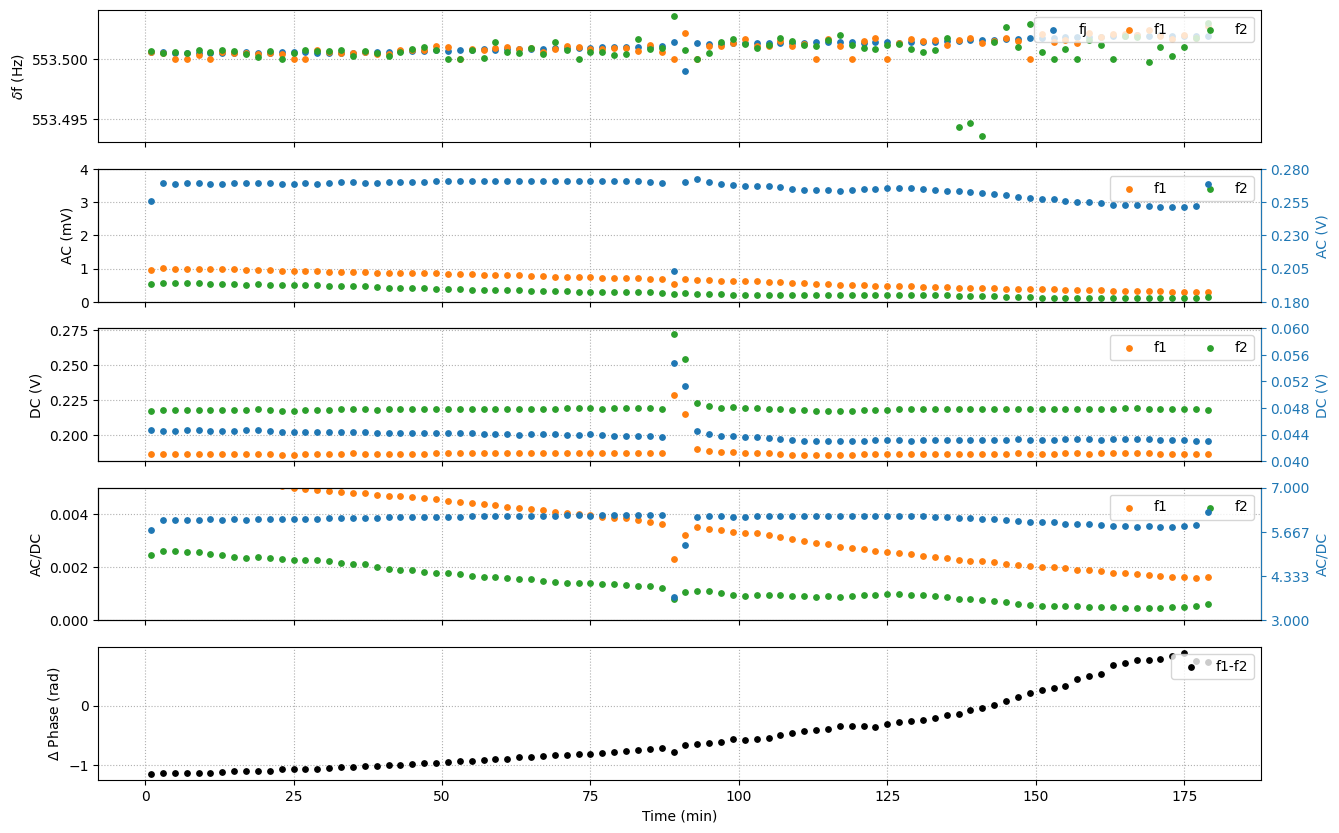

In [161]:
def __makeplot(df):

    Nrow, Ncol = 5, 1

    font = 12
    ms = 15

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    t_axis = (np.array(range(len(df['fj_fs'])))+0.5)*config['interval']/60

    ax[0].scatter(t_axis, df['fj_fs'], zorder=2, s=ms, label="fj")
    ax[0].scatter(t_axis, df['f1_fs'], zorder=2, s=ms, label="f1")
    ax[0].scatter(t_axis, df['f2_fs'], zorder=2, s=ms, label="f2")
    ax[0].set_ylabel("$\delta$f (Hz)")
    ax[0].ticklabel_format(useOffset=False)

    # ax[1].scatter(t_axis, df['fj_ac'], zorder=2, s=ms, label="fj")
    ax[1].scatter(t_axis, df['f1_ac']*1e3, zorder=2, s=ms, label="f1", color="tab:orange")
    ax[1].scatter(t_axis, df['f2_ac']*1e3, zorder=2, s=ms, label="f2", color="tab:green")
    ax[1].set_ylabel("AC (mV)")
    ax[1].set_ylim(0, 4)

    ax11 = ax[1].twinx()
    ax11.scatter(t_axis, df['fj_ac'], zorder=2, s=ms, label="fj")
    ax11.set_ylabel("AC (V)")
    ax11.spines['right'].set_color('tab:blue')
    ax11.yaxis.label.set_color('tab:blue')
    ax11.tick_params(axis='y', colors='tab:blue')
    ax11.set_yticks(np.linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))

    # ax[2].scatter(t_axis, df['fj_dc'], zorder=2, s=ms, label="fj")
    ax[2].scatter(t_axis, df['f1_dc'], zorder=2, s=ms, label="f1", color="tab:orange")
    ax[2].scatter(t_axis, df['f2_dc'], zorder=2, s=ms, label="f2", color="tab:green")
    ax[2].set_ylabel("DC (V)")
    # ax[2].set_ylim(0.7, 1)

    ax21 = ax[2].twinx()
    ax21.scatter(t_axis, df['fj_dc'], zorder=2, s=ms, label="fj")
    ax21.set_ylabel("DC (V)")
    ax21.spines['right'].set_color('tab:blue')
    ax21.yaxis.label.set_color('tab:blue')
    ax21.tick_params(axis='y', colors='tab:blue')
    ax21.set_yticks(np.linspace(ax21.get_yticks()[0], ax21.get_yticks()[-1], len(ax[2].get_yticks())))

    # ax[3].scatter(t_axis, df['fj_ac']/df['fj_dc'], zorder=2, s=ms, label="fj")
    ax[3].scatter(t_axis, df['f1_ac']/df['f1_dc'], zorder=2, s=ms, label="f1", color="tab:orange")
    ax[3].scatter(t_axis, df['f2_ac']/df['f2_dc'], zorder=2, s=ms, label="f2", color="tab:green")
    ax[3].set_ylabel("AC/DC")
    ax[3].set_ylim(0, 5e-3)

    ax31 = ax[3].twinx()
    ax31.scatter(t_axis, df['fj_ac']/df['fj_dc'], zorder=2, s=ms, label="fj")
    ax31.set_ylabel("AC/DC")
    ax31.spines['right'].set_color('tab:blue')
    ax31.yaxis.label.set_color('tab:blue')
    ax31.tick_params(axis='y', colors='tab:blue')
    ax31.set_yticks(np.linspace(ax31.get_yticks()[0], ax31.get_yticks()[-1], len(ax[3].get_yticks())))

    ax[4].scatter(t_axis, df['f1_ph']-df['f2_ph'], color="k", zorder=2, s=ms, label="f1-f2")
    ax[4].set_ylabel("$\Delta$ Phase (rad)")
    # ax[4].set_yscale("log")

    ax[4].set_xlabel("Time (min)")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1, ncol=3)

    plt.show();
    return fig

fig = __makeplot(out_df);

# fig.savefig(config['path_to_figs']+f"SF_BS_{config['ring']}_{method}_values.png", format="png", dpi=150, bbox_inches='tight')


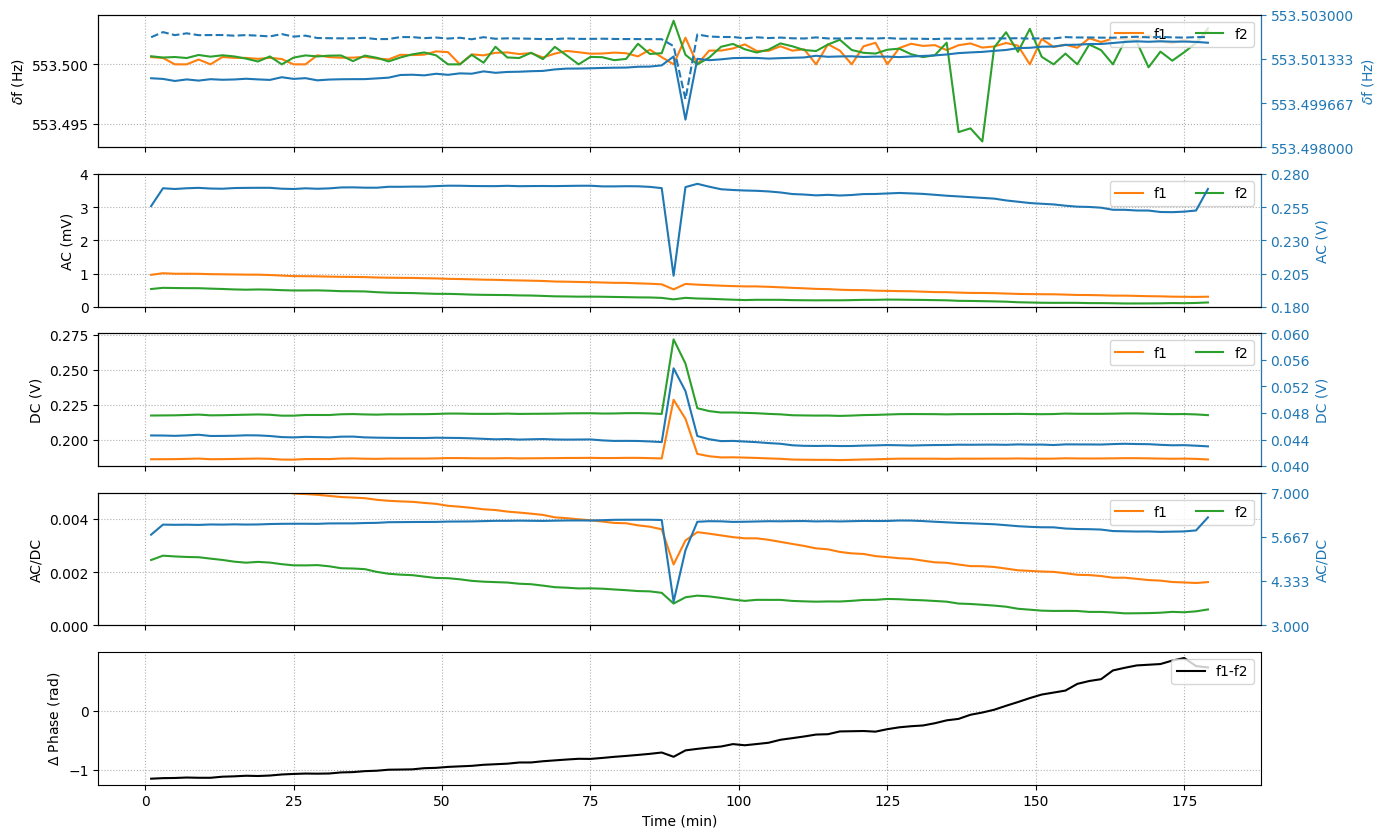

In [162]:
def __makeplot2(df):

    Nrow, Ncol = 5, 1

    font = 12
    ms = 15

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    t_axis = (np.array(range(len(df['fj_fs'])))+0.5)*config['interval']/60

    ax[0].plot(t_axis, df['f1_fs'], zorder=2, label="f1", color="tab:orange")
    ax[0].plot(t_axis, df['f2_fs'], zorder=2, label="f2", color="tab:green")
    ax[0].set_ylabel("$\delta$f (Hz)")
    ax[0].ticklabel_format(useOffset=False)


    ax00 = ax[0].twinx()
    ax00.plot(t_axis, df['fj_fs'], zorder=2, label="fj", color="tab:blue")
    ax00.plot(t_axis, df['w_s'], zorder=2, label="bs", ls="--", color="tab:blue")
    ax00.set_ylabel("$\delta$f (Hz)")
    ax00.spines['right'].set_color('tab:blue')
    ax00.yaxis.label.set_color('tab:blue')
    ax00.tick_params(axis='y', colors='tab:blue')
    ax00.set_yticks(np.linspace(ax00.get_yticks()[0], ax00.get_yticks()[-1], len(ax[0].get_yticks())))
    ax00.ticklabel_format(useOffset=False)

    ax[1].plot(t_axis, df['f1_ac']*1e3, zorder=2, label="f1", color="tab:orange")
    ax[1].plot(t_axis, df['f2_ac']*1e3, zorder=2, label="f2", color="tab:green")
    ax[1].set_ylabel("AC (mV)")
    ax[1].set_ylim(0, 4)

    ax11 = ax[1].twinx()
    ax11.plot(t_axis, df['fj_ac'], zorder=2, label="fj")
    ax11.set_ylabel("AC (V)")
    ax11.spines['right'].set_color('tab:blue')
    ax11.yaxis.label.set_color('tab:blue')
    ax11.tick_params(axis='y', colors='tab:blue')
    ax11.set_yticks(np.linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))

    ax[2].plot(t_axis, df['f1_dc'], zorder=2, label="f1", color="tab:orange")
    ax[2].plot(t_axis, df['f2_dc'], zorder=2, label="f2", color="tab:green")
    ax[2].set_ylabel("DC (V)")

    ax21 = ax[2].twinx()
    ax21.plot(t_axis, df['fj_dc'], zorder=2, label="fj")
    ax21.set_ylabel("DC (V)")
    ax21.spines['right'].set_color('tab:blue')
    ax21.yaxis.label.set_color('tab:blue')
    ax21.tick_params(axis='y', colors='tab:blue')
    ax21.set_yticks(np.linspace(ax21.get_yticks()[0], ax21.get_yticks()[-1], len(ax[2].get_yticks())))

    ax[3].plot(t_axis, df['f1_ac']/df['f1_dc'], zorder=2, label="f1", color="tab:orange")
    ax[3].plot(t_axis, df['f2_ac']/df['f2_dc'], zorder=2, label="f2", color="tab:green")
    ax[3].set_ylabel("AC/DC")
    ax[3].set_ylim(0, 5e-3)

    ax31 = ax[3].twinx()
    ax31.plot(t_axis, df['fj_ac']/df['fj_dc'], zorder=2, label="fj")
    ax31.set_ylabel("AC/DC")
    ax31.spines['right'].set_color('tab:blue')
    ax31.yaxis.label.set_color('tab:blue')
    ax31.tick_params(axis='y', colors='tab:blue')
    ax31.set_yticks(np.linspace(ax31.get_yticks()[0], ax31.get_yticks()[-1], len(ax[3].get_yticks())))

    ax[4].plot(t_axis, df['f1_ph']-df['f2_ph'], color="k", zorder=2, label="f1-f2")
    ax[4].set_ylabel("$\Delta$ Phase (rad)")
    # ax[4].set_yscale("log")

    ax[4].set_xlabel("Time (min)")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1, ncol=3)

    plt.show();
    return fig

fig = __makeplot2(out_df);

# fig.savefig(config['path_to_figs']+f"SF_BS_{config['ring']}_{method}_values.png", format="png", dpi=150, bbox_inches='tight')


## Beat Data

In [73]:
def __load_beat(tbeg, tend, ring, path_to_data):

    from datetime import date
    from pandas import read_pickle, concat, DataFrame, date_range
    from obspy import UTCDateTime

    tbeg, tend = UTCDateTime(tbeg), UTCDateTime(tend)

    dd1 = date.fromisoformat(str(tbeg.date))
    dd2 = date.fromisoformat(str(tend.date))

    year = str(tbeg.year)

    df = DataFrame()
    for dat in date_range(dd1, dd2):
        file = f"{year}/R{ring}/FJ{ring}_"+str(dat)[:10].replace("-", "")+".pkl"
        try:
            df0 = read_pickle(path_to_data+file)
            df = concat([df, df0])
        except:
            print(f"error for {file}")

    ## trim to defined times
    df = df[(df.times_utc >= tbeg) & (df.times_utc < tend)]

    ## correct seconds
    df['times_utc_sec'] = [abs(tbeg - UTCDateTime(_t))  for _t in df['times_utc']]

    return df

In [74]:
# t1, t2 = UTCDateTime(out_df['time1'][0]), UTCDateTime(out_df['time1'][0])+len(out_df['time1'])*interval

# # data = __load_beat(t1, t2, config['seed'].split(".")[3][2], config['path_to_data'])
# data = out_df

# w_obs = data['fj_fs']

## Compute Backscatter Correction

## Plotting

## Change of CM factor

In [ ]:
ws = []
cm = [0.01, 0.1, 1.0, 2.0]
for cm_f_f in cm:
    _ws = __backscatter_correction(m01, m02, phase0, w_obs, cm_filter_factor=cm_f_f)
    ws.append(_ws)

In [ ]:
def __makeplot():

    Nrow, Ncol = 5, 1

    font = 12
    ms = 15

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    t_axis = (np.array(range(len(out_df['fj_fs'])))+0.5)*interval/60

    ax[0].plot(t_axis, w_obs, color="k", label="$\omega_{obs}$", zorder=2)
    # ax[0].plot(t_axis, w_s, color="r", label="$\omega_{s}$ = $\omega_{obs}$ - BS correction")
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\delta$f$_{obs}$ (Hz)")

    for _ws, _cm in zip(ws, cm):
        ax[0].plot(t_axis, _ws, label=f"cm={_cm}", zorder=1)


    ax[1].plot(t_axis, m01, label="m01")
    ax[1].plot(t_axis, m02, label="m02")
    ax[1].set_ylabel("fractional modulation")

    ax[2].plot(t_axis, phase, color="k", label=r"$\theta$1 - $\theta$2")
    ax[2].set_ylabel(" $\Delta$ phase (rad)")

    # ax[3].plot(t_axis, M, color="k", label="M")
    ax[3].plot(t_axis, (4+M)/(4-M), color="k", label="(4+M)/(4-M))")
    ax[3].set_ylabel("BS faktor")
    ax[3].ticklabel_format(useOffset=False)

    ax[4].plot(t_axis, correction, color="k", label="BS correction = ((4+M)/(4-M) -1)*303.05")
    # ax[4].set_ylabel("$\delta$f$_{corrected}$ (Hz)")
    ax[4].set_ylabel("BS correction (Hz)")
    ax[4].ticklabel_format(useOffset=False)

    ax[4].set_xlabel("Time (min)")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1, ncol=3)

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_frequencyomain_{method}_{interval}_cm_test.png", format="png", dpi=200, bbox_inches='tight')


In [ ]:
import numpy as np

import matplotlib.pyplot as plt

from scipy.signal import hilbert, chirp
from scipy.signal import get_window
from scipy.signal.windows import dpss

duration = 1.0

fs = 400.0

samples = int(fs*duration)

t = np.arange(samples) / fs

signal = chirp(t, 20.0, t[-1], 100.0)

signal *= (1.0 + 0.5 * np.sin(2.0*np.pi*3.0*t) )

NN = len(signal)

# win = dpss(NN, 1, Kmax=None, sym=True, norm=None)
win = get_window("cosine", NN)

signal *= win

analytic_signal = hilbert(signal, N=500)

amplitude_envelope = np.abs(analytic_signal)

instantaneous_phase = np.unwrap(np.angle(analytic_signal))

instantaneous_frequency = (np.diff(instantaneous_phase) /(2.0*np.pi) * fs)

print(len(amplitude_envelope))
amplitude_envelope = amplitude_envelope[:NN]
instantaneous_phase = instantaneous_phase[:NN]
instantaneous_frequency = instantaneous_frequency[:NN]


fig, (ax0, ax1) = plt.subplots(nrows=2)

ax0.plot(t, signal, label='signal')

ax0.plot(t, amplitude_envelope, label='envelope')

ax0.set_xlabel("time in seconds")

ax0.legend()

ax1.plot(t[1:], instantaneous_frequency[:-1])

ax1.set_xlabel("time in seconds")

ax1.set_ylim(0.0, 120.0)

fig.tight_layout()


In [ ]:
from scipy.signal.windows import dpss

In [ ]:
swin = dpss(NN, 2, Kmax=3, sym=True, norm=None)

In [ ]:
for s in swin:
    plt.plot(s)

In [ ]:
swin[0]